<a href="https://colab.research.google.com/github/judyschen/Profolio/blob/main/Kaggle_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install --upgrade tensorflow


# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [14]:
#basic imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

#pre-processing imports
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#Word Embeddings
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import keras_core as keras


#imports related to modeling
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
!git clone https://github.com/judyschen/Profolio.git

Cloning into 'Profolio'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 3), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (20/20), 4.08 MiB | 3.38 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [16]:
# Load the training and test datasets
train_df = pd.read_csv("Profolio/kaggleNLP_train.csv", index_col=0)
test_df = pd.read_csv("Profolio/kaggleNLP_test.csv", index_col=0)

In [17]:
# Display the first few rows of the training dataset to understand its structure
train_df.head()




,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
# Display the first few rows of the test dataset to understand its structure
test_df.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


#Data cleaning

In [19]:
#we are dropping the location of the tweet
train_df.drop('location', axis = 1, inplace = True)
test_df.drop('location', axis = 1, inplace = True)

In [20]:
train_df["length"] = train_df["text"].apply(lambda x : len(x))
test_df["length"] = test_df["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(train_df["length"].describe())
print()

print("Test Length Stat")
print(test_df["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


We see a similar distribution of word count in the two datasets
Average of 15 words are occuring each tweet before preprocessing

In [21]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

keyword    61
text        0
target      0
length      0
dtype: int64
keyword    26
text        0
length      0
dtype: int64


In [22]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Removing URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Handling contractions
    contractions = {
        "ain't": "is not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "could've": "could have",
        "couldn't": "could not",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'll": "he will",
        "he's": "he is",
        "how'd": "how did",
        "how'll": "how will"
    }
    text = ' '.join([contractions[word] if word in contractions else word for word in text.split()])

    # Removing special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Joining tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

  # Apply preprocessing to training data
train_df['processed_text'] = train_df['text'].apply(preprocess_text)

# Apply the same preprocessing to testing data
test_df['processed_text'] = test_df['text'].apply(preprocess_text)


In [23]:
print(train_df['processed_text'].head())
print(test_df['processed_text'].head())

id
1           deed reason earthquake may allah forgive u
4                forest fire near la ronge sask canada
5    resident asked shelter place notified officer ...
6    people receive wildfire evacuation order calif...
7    got sent photo ruby alaska smoke wildfire pour...
Name: processed_text, dtype: object
id
0                           happened terrible car crash
2     heard earthquake different city stay safe ever...
3     forest fire spot pond goose fleeing across str...
9                  apocalypse lighting spokane wildfire
11                   typhoon soudelor kill china taiwan
Name: processed_text, dtype: object


Split the training set into a training set and validation set

In [24]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train_df.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

np.random.seed(0)
keras.utils.set_random_seed(0)

In [25]:
X = train_df["processed_text"]
y = train_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = test_df["processed_text"]

#Word embedding
Convert from text to vectors

 Vectorize text data using TF-IDF

In [26]:
# Initialize TfidfVectorizer and fit only on training data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform both training and validation data using the same vocabulary
X_train_embedded = tfidf_vectorizer.transform(X_train)
X_val_embedded = tfidf_vectorizer.transform(X_val)

This is the second word embedding, that we use countVectorizer
In the end, we found that the score is higer than TF-IDF

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer and fit only on training data
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)

# Transform both training and validation data using the same vocabulary
X_train_embedded = count_vectorizer.transform(X_train)
X_val_embedded = count_vectorizer.transform(X_val)


In [28]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    try:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true,
            np.argmax(y_pred, axis=1),
            display_labels=["Not Disaster","Disaster"],
            cmap=plt.cm.Blues
        )
        tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    except Exception as e:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true,
            y_pred,
            display_labels=["Not Disaster","Disaster"],
            cmap=plt.cm.Blues
        )
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

# Gradient Boosting

Validation Accuracy (Gradient Boosting): 0.7426132632961261
Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           0       0.71      0.93      0.81       874
           1       0.85      0.48      0.62       649

    accuracy                           0.74      1523
   macro avg       0.78      0.71      0.71      1523
weighted avg       0.77      0.74      0.73      1523



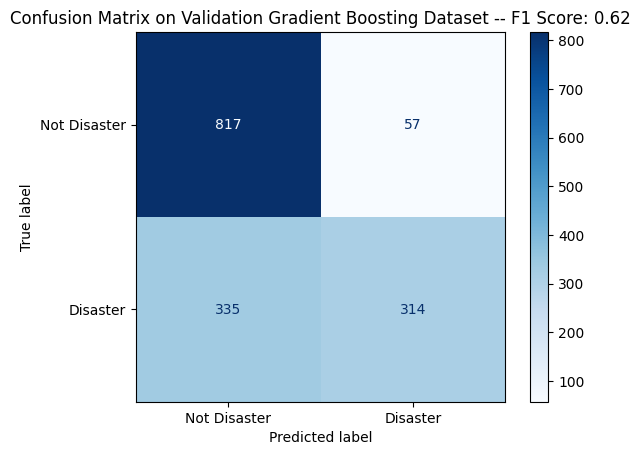

In [29]:
# Initialize and train the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train_embedded, y_train)

# Make predictions on the validation set
y_pred_val_gb = gb_classifier.predict(X_val_embedded)

# Calculate and print accuracy
accuracy_gb = accuracy_score(y_val, y_pred_val_gb)
print("Validation Accuracy (Gradient Boosting):", accuracy_gb)

# Print classification report
print("Classification Report (Gradient Boosting):\n", classification_report(y_val, y_pred_val_gb))

# Display confusion matrix
displayConfusionMatrix(y_val, y_pred_val_gb, "Validation Gradient Boosting")

#Random Forest

Validation Accuracy (Random Forest): 0.7839789888378201
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.77      0.88      0.82       874
           1       0.81      0.65      0.72       649

    accuracy                           0.78      1523
   macro avg       0.79      0.77      0.77      1523
weighted avg       0.79      0.78      0.78      1523



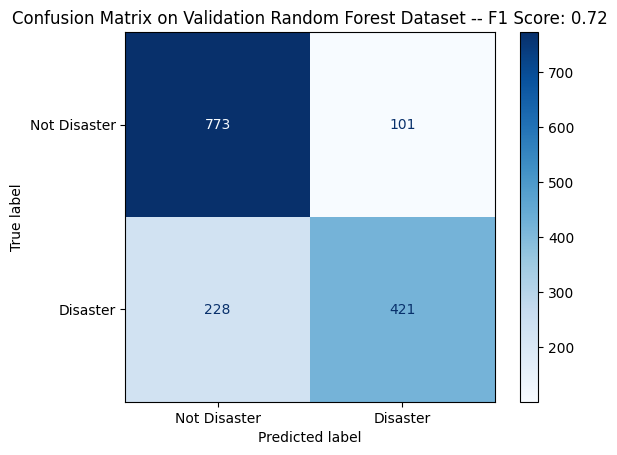

In [30]:
# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_embedded, y_train)

# Make predictions on the validation set
y_pred_val_rf = rf_classifier.predict(X_val_embedded)

# Calculate and print accuracy
accuracy_rf = accuracy_score(y_val, y_pred_val_rf)
print("Validation Accuracy (Random Forest):", accuracy_rf)

# Print classification report
print("Classification Report (Random Forest):\n", classification_report(y_val, y_pred_val_rf))

# Display confusion matrix
displayConfusionMatrix(y_val, y_pred_val_rf, "Validation Random Forest")


# Logistic Regression

In [31]:
logit = LogisticRegression()

In [32]:
logit.fit(X_train_embedded, y_train)

LogisticRegression()

In [33]:
logit.score(X_train_embedded, y_train)

0.9599343185550082

In [34]:
logit.score(X_val_embedded, y_val)

0.7951411687458962

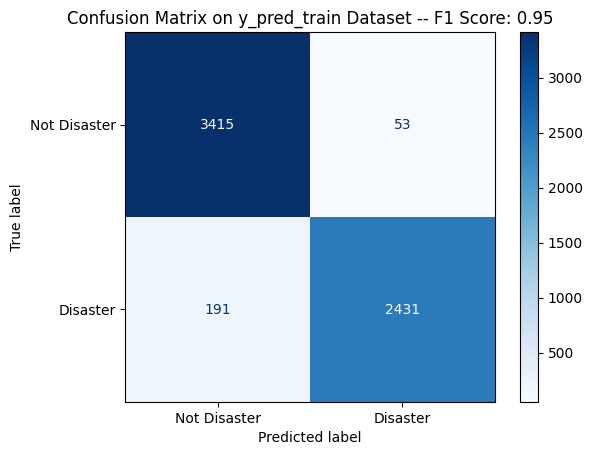

In [35]:
y_pred_train = logit.predict(X_train_embedded)

displayConfusionMatrix(y_train, y_pred_train, "y_pred_train")

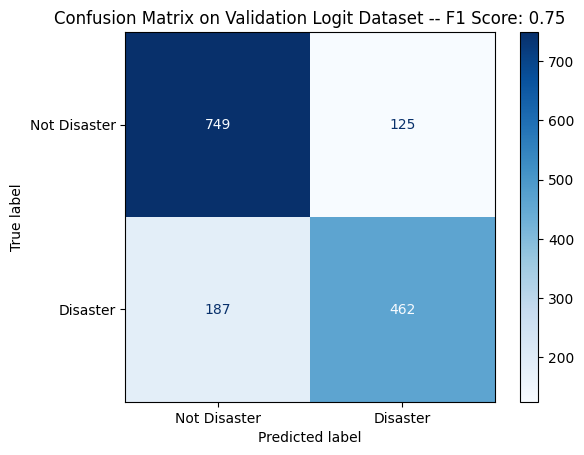

In [36]:
y_pred_val = logit.predict(X_val_embedded)

displayConfusionMatrix(y_val, y_pred_val, "Validation Logit")

In [37]:
# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy (Random Forest):", accuracy)

# Print classification report
print("Classification Report (Random Forest):\n", classification_report(y_val, y_pred_val))

Validation Accuracy (Random Forest): 0.7951411687458962
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       874
           1       0.79      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.80      0.79      1523



#Submit

In [39]:
sub=pd.read_csv("Profolio/sample_submission_NLP.csv")

In [40]:
x_test = test_df['processed_text']
X_test = tfidf_vectorizer.transform(x_test)

In [41]:
#lg = LogisticRegression()
y_predd = logit.predict(X_test)

In [42]:
#  submission file
submission_df = pd.DataFrame({'id': sub['id'], 'target': y_predd})
submission_df.to_csv('submission.csv', index=False)